# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [2]:
import pandas as pd
#import caffeine

train_data = pd.read_csv('research-articles-dataset/train.csv').sample(frac=1)
test_data = pd.read_csv('research-articles-dataset/test.csv').sample(frac=1)

In [3]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8129,8130,Model-independent analyses of non-Gaussianity ...,"Despite the wealth of $Planck$ results, ther...",0,1,0,0,0,0
4339,4340,A Hand Combining Two Simple Grippers to Pick u...,This paper proposes a novel robotic hand des...,1,0,0,0,0,0
16020,16021,Interpreting and using CPDAGs with background ...,We develop terminology and methods for worki...,0,0,1,1,0,0
13288,13289,"Fairer and more accurate, but for whom?",Complex statistical machine learning models ...,1,0,0,1,0,0
8476,8477,Test results of a prototype device to calibrat...,A Large Size air Cherenkov Telescope (LST) p...,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
14301,14302,Topology and edge modes in quantum critical ch...,We show that topology can protect exponentia...,0,1,0,0,0,0
2755,2756,Recurrent Deep Embedding Networks for Genotype...,The understanding of variations in genome se...,0,0,0,0,1,0
2524,2525,Justifications in Constraint Handling Rules fo...,We present a straightforward source-to-sourc...,1,0,0,0,0,0
5588,5589,Cloud Radiative Effect Study Using Sky Camera,The analysis of clouds in the earth's atmosp...,1,1,0,0,0,0


In [4]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [5]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [6]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

### Compute number of unique words (vocabulary size)

In [7]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

16903

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (2500, 1984))

### Create a index-to-word map

In [9]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [11]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [12]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [13]:
from sklearn.decomposition import TruncatedSVD

In [18]:
# Your code goes here
# BOW
svd_model = TruncatedSVD(n_components=K).fit(X_bow)
dictionary = bow_featurizer.get_feature_names()
projected_matrix = pd.DataFrame(svd_model.components_, index = range(1,11), columns = (dictionary)).T

#print(encoding_matrix)
for col in projected_matrix.columns:
    
    projected_matrix = projected_matrix.sort_values(col, ascending=False)
    print(col, list(projected_matrix.index[:K]))

1 ['number', 'model', 'result', 'method', 'time', 'datum', 'network', 'problem', 'base', 'algorithm']
2 ['number', 'rm', 'frac', 'mu', 'galaxy', 'mathbb', 'nu', 'm_', 'sim', 'alpha']
3 ['model', 'parameter', 'datum', 'field', 'star', 'inference', 'effect', 'study', 'temperature', 'phase']
4 ['network', 'model', 'neural', 'deep', 'number', 'training', 'learning', 'datum', 'train', 'convolutional']
5 ['network', 'field', 'study', 'theory', 'group', 'time', 'structure', 'magnetic', 'equation', 'graph']
6 ['problem', 'algorithm', 'graph', 'model', 'solution', 'time', 'learn', 'polynomial', 'set', 'optimal']
7 ['datum', 'feature', 'analysis', 'machine', 'data', 'performance', 'algorithm', 'technique', 'human', 'user']
8 ['datum', 'method', 'network', 'distribution', 'problem', 'set', 'graph', 'function', 'study', 'estimate']
9 ['group', 'result', 'mathbb', 'image', 'learning', 'learn', 'function', 'deep', 'structure', 'set']
10 ['problem', 'star', 'galaxy', 'function', 'mass', 'distribution

In [19]:
projected_matrix

,1,2,3,4,5,6,7,8,9,10
problem,0.051697,-0.157806,-0.071936,-0.260794,0.042766,0.437577,-0.090916,0.119213,-0.010801,0.328119
star,0.025303,0.004536,0.037634,0.001289,0.028503,-0.090806,0.012238,0.024621,-0.019215,0.210230
galaxy,0.023927,0.007281,0.024553,0.001740,0.021094,-0.076656,0.008264,0.011315,-0.016874,0.179941
function,0.032373,-0.073363,0.021824,-0.100870,0.050961,0.043403,-0.091995,0.080911,0.125371,0.131828
mass,0.021214,0.002229,0.031172,-0.003425,0.033934,-0.057629,-0.005126,-0.004614,-0.021732,0.128111
...,...,...,...,...,...,...,...,...,...,...
group,0.024203,-0.015329,-0.019439,-0.043863,0.115277,0.024871,0.012309,0.069915,0.255406,-0.124439
feature,0.025575,-0.082546,-0.023102,0.016403,-0.113611,-0.067202,0.101577,-0.132935,0.041394,-0.130530
space,0.027139,-0.051732,0.022842,-0.080983,0.055680,0.023760,-0.045614,0.014818,0.087471,-0.156957
graph,0.021083,-0.050390,-0.045974,-0.075891,0.089536,0.190270,-0.038264,0.088320,0.007035,-0.360062


In [20]:
# TF-IDF
svd_model = TruncatedSVD(n_components=K).fit(X_tfidf)
dictionary = tfidf_featurizer.get_feature_names()
projected_matrix = pd.DataFrame(svd_model.components_, index = range(1,11), columns = (dictionary)).T
for col in projected_matrix.columns:
    projected_matrix = projected_matrix.sort_values(col, ascending=False)
    print(col, list(projected_matrix.index[:K]))

1 ['number', 'model', 'network', 'method', 'datum', 'problem', 'algorithm', 'propose', 'result', 'time']
2 ['number', 'mathbb', 'star', 'galaxy', 'frac', 'magnetic', 'spin', 'rm', 'group', 'temperature']
3 ['number', 'network', 'neural', 'deep', 'learning', 'learn', 'training', 'image', 'task', 'train']
4 ['magnetic', 'spin', 'field', 'phase', 'temperature', 'electron', 'interaction', 'effect', 'model', 'state']
5 ['network', 'group', 'graph', 'neural', 'mathbb', 'theory', 'node', 'algebra', 'manifold', 'prove']
6 ['algorithm', 'problem', 'method', 'optimization', 'solution', 'time', 'optimal', 'magnetic', 'state', 'solve']
7 ['network', 'node', 'distribution', 'problem', 'galaxy', 'star', 'estimator', 'rate', 'time', 'stochastic']
8 ['image', 'neural', 'deep', 'training', 'adversarial', 'equation', 'function', 'method', 'distribution', 'gradient']
9 ['equation', 'solution', 'model', 'robot', 'differential', 'human', 'control', 'time', 'game', 'existence']
10 ['image', 'galaxy', 'metho

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

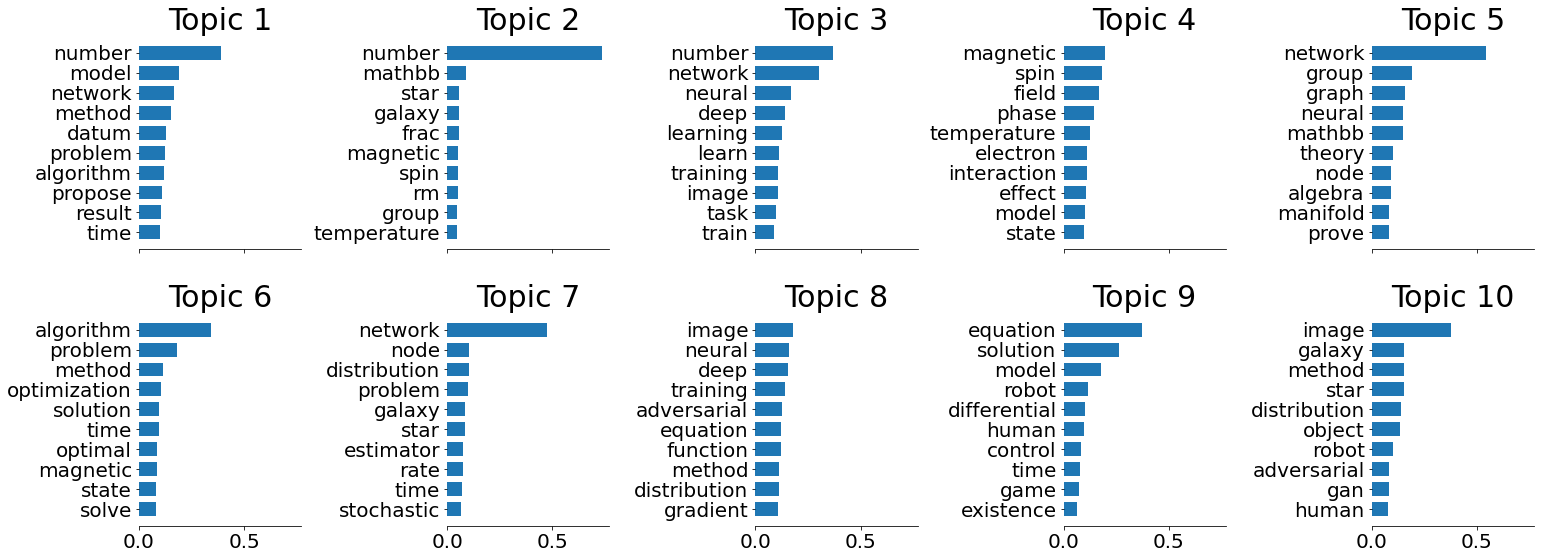

In [21]:
plot_top_words(svd_model, tfidf_featurizer.get_feature_names(), K, "")

3. K is the rank of the projected data. K represents number of different topics.

4. Methods that detect the significant change of objective function, such as Elbow can be used to determine an appropriate value of K.

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

In [15]:
from sklearn.decomposition import NMF

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

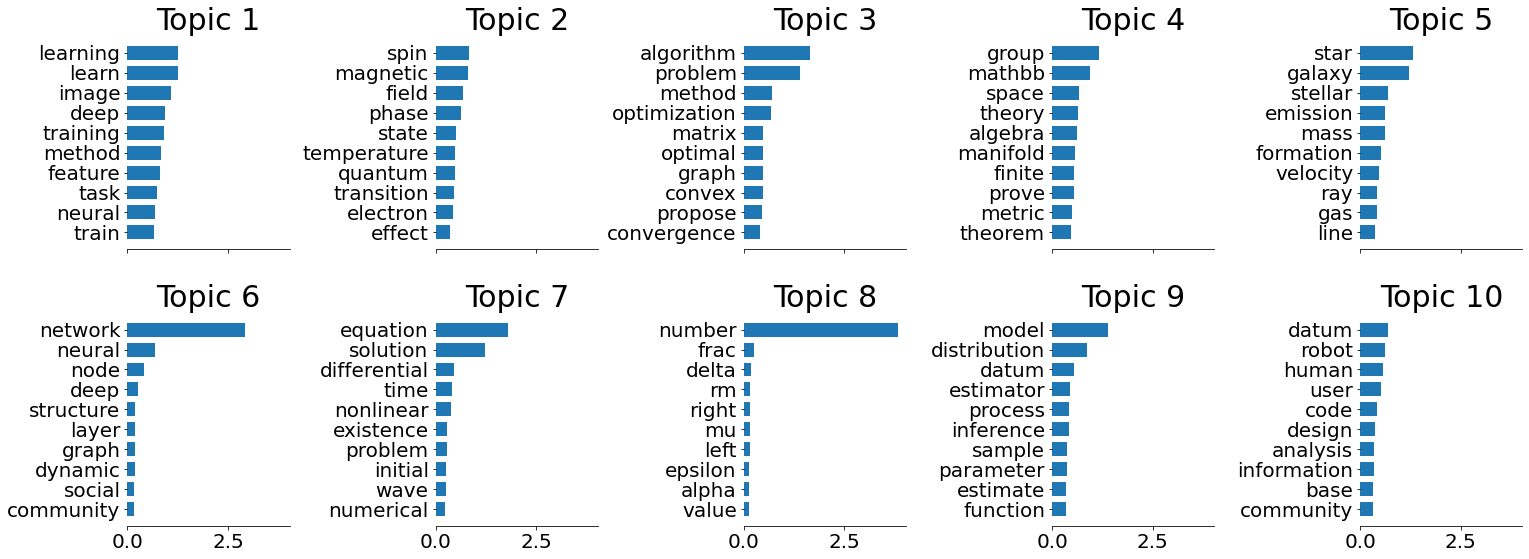

In [22]:
# Your code goes here
nmf_model = NMF(n_components=K, init='random', random_state=917)
nmf_model.fit(X_tfidf)
plot_top_words(nmf_model, tfidf_featurizer.get_feature_names(), K, "")

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

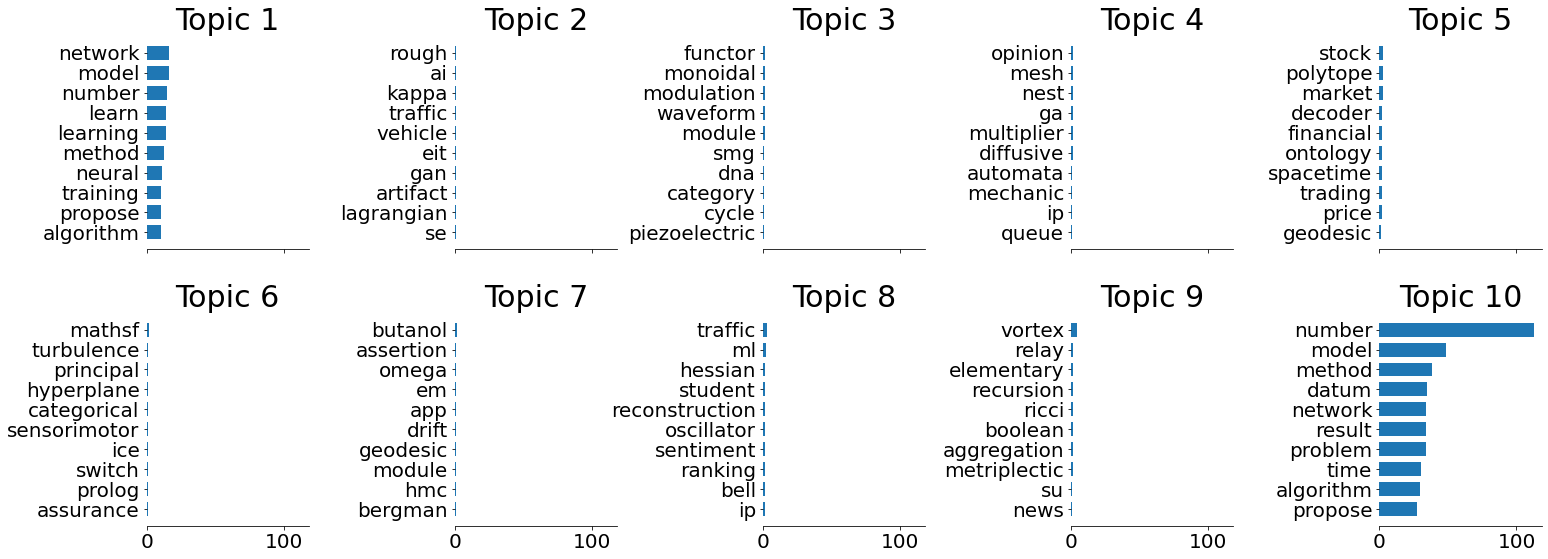

In [26]:
# Your code goes here
lda_model = LatentDirichletAllocation(n_components=K, random_state=917)
lda_model.fit(X_tfidf)
plot_top_words(lda_model, tfidf_featurizer.get_feature_names(), K, "")

### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [27]:
# Your code goes here
test_sentences = []
for i, d in enumerate(test_data['ABSTRACT']):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    test_sentences.append(d)
    
test_docs = []
for sent in test_sentences:
    test_docs.append(pipeline(sent))
tfidf_test = tfidf_featurizer.transform(test_docs)

In [28]:
len(test_data)

8989

In [29]:
svd_trans = svd_model.transform(tfidf_test)
svd_trans

array([[ 0.0925527 , -0.0187461 , -0.03176778, ..., -0.00787722,
         0.01826007, -0.07331868],
       [ 0.17074698, -0.07378587,  0.06668438, ...,  0.02359255,
         0.01424284, -0.04060859],
       [ 0.12231927,  0.12198128,  0.00022716, ...,  0.0025144 ,
        -0.01157106, -0.0010788 ],
       ...,
       [ 0.14536041, -0.07991987, -0.05627634, ..., -0.02917116,
         0.08099596, -0.04331738],
       [ 0.14755472,  0.19605751,  0.05709111, ..., -0.00548348,
         0.00670988, -0.01159233],
       [ 0.10824296,  0.06158524,  0.03366471, ..., -0.02715881,
         0.02135011, -0.00560047]])

In [30]:
nfm_trans = nmf_model.transform(tfidf_test)
nfm_trans

array([[0.00276011, 0.02678075, 0.        , ..., 0.        , 0.03214   ,
        0.00075896],
       [0.02821676, 0.00174554, 0.00646605, ..., 0.00830665, 0.01319556,
        0.01115452],
       [0.00089972, 0.        , 0.00210661, ..., 0.03806244, 0.00272504,
        0.        ],
       ...,
       [0.0064595 , 0.        , 0.04105551, ..., 0.        , 0.0064687 ,
        0.01810925],
       [0.        , 0.00208859, 0.        , ..., 0.06265526, 0.        ,
        0.        ],
       [0.00212471, 0.00369183, 0.        , ..., 0.02670401, 0.01413358,
        0.01451927]])

In [31]:
lda_trans = lda_model.transform(tfidf_test)
lda_trans

array([[0.01621966, 0.0162235 , 0.016219  , ..., 0.01621973, 0.01621917,
        0.78300737],
       [0.31032018, 0.01063096, 0.01063131, ..., 0.10360276, 0.01063498,
        0.51165341],
       [0.02310996, 0.02310718, 0.02310707, ..., 0.02310707, 0.02310707,
        0.79203337],
       ...,
       [0.09613975, 0.0171782 , 0.01717712, ..., 0.01719089, 0.01717712,
        0.76637876],
       [0.23453376, 0.02204673, 0.02204681, ..., 0.02204944, 0.02204673,
        0.58908961],
       [0.0557292 , 0.16219571, 0.01366464, ..., 0.01366108, 0.01366183,
        0.60123171]])